# Final project for PUI2018

Dear Professor or TA, this notebook was written in google colab and some of the interactive maps might not display well in CUSP ADRF. 
Please read the notebook on Google Colab, thanks a lot.
Here is a link: https://colab.research.google.com/notebooks/welcome.ipynb#recent=true

## **Setting the environment**

In [0]:
!pip install geopandas

    100% |████████████████████████████████| 901kB 16.0MB/s 
    100% |████████████████████████████████| 4.4MB 3.9MB/s 
    100% |████████████████████████████████| 1.4MB 11.3MB/s 
    100% |████████████████████████████████| 17.8MB 1.1MB/s 
  Running setup.py bdist_wheel for pyproj ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/89/77/ec/a537585d1022dafde0317dd19d33c4a30d4ee61e19f25ebd8e
  Running setup.py bdist_wheel for munch ... - done
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe

In [0]:
#set the environment

#initial imports
import pylab as pl
import pandas as pd

#added to use the env variable PUI
import os

#added to get data from the internet
import urllib
import requests

#geospatial imports
import geopandas as gp
import shapely
from fiona.crs import from_epsg

#for modeling
import sklearn.preprocessing as preprocessing
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.ensemble  import GradientBoostingClassifier as gdb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# **1 1. Collect the school related data**

## **1.1 Collect School SAT Data**

In [0]:
school_sat_data = pd.read_csv("https://data.cityofnewyork.us/api/views/f9bf-2cp4/rows.csv?accessType=DOWNLOAD")

In [0]:
school_sat_data.tail(10)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
468,75K371,P.S. 371 s LILLIAN L. RASHKIS,s,s,s,s
469,75M035,P.S. 035,s,s,s,s
470,75Q256,P.S. Q256,s,s,s,s
471,75Q811,P.S. Q811,32,429,444,433
472,75R025,SOUTH RICHMOND HIGH SCHOOL I.S./P.S. 25,s,s,s,s
473,75X012,P.S. X012 LEWIS AND CLARK SCHOOL,s,s,s,s
474,75X754,J. M. RAPPORT SCHOOL CAREER DEVELOPMENT,s,s,s,s
475,79M645,SCHOOL FOR COOPERATIVE TECHNICAL EDUCATION,s,s,s,s
476,79Q950,GED PLUS s CITYWIDE,8,496,400,426
477,79X490,PHOENIX ACADEMY,9,367,370,360


I am not sure what 's' in some of the rows mean, so I will drop these rows.

In [0]:
school_sat_data.shape

(478, 6)

In [0]:
#some rows contain 's', so i need to clean the data
school_sat_data=school_sat_data[ ~ school_sat_data['SAT Critical Reading Avg. Score'].str.contains('s') ]
school_sat_data=school_sat_data[ ~ school_sat_data['SAT Math Avg. Score'].str.contains('s') ]
school_sat_data=school_sat_data[ ~ school_sat_data['SAT Writing Avg. Score'].str.contains('s') ]

In [0]:
school_sat_data.shape

(421, 6)

In [0]:
school_sat_data.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


In [0]:
school_sat_data[['SAT Critical Reading Avg. Score']] = school_sat_data[['SAT Critical Reading Avg. Score']].astype(float)
school_sat_data[['SAT Math Avg. Score']] = school_sat_data[['SAT Math Avg. Score']].astype(float)
school_sat_data[['SAT Writing Avg. Score']] = school_sat_data[['SAT Writing Avg. Score']].astype(float)

In [0]:
school_sat_data['SAT AVG']=(school_sat_data['SAT Critical Reading Avg. Score']+school_sat_data['SAT Math Avg. Score']+school_sat_data['SAT Writing Avg. Score'])*1/3

In [0]:
school_sat_data[['SAT AVG']] = school_sat_data[['SAT AVG']].astype(float)

In [0]:
school_sat_data.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT AVG
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,374.000000
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,390.666667
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,383.000000
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,391.333333
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,402.333333


#**1.2 Collect School Crime Data**

In [0]:
school_crime_data_raw = pd.read_csv('https://data.cityofnewyork.us/api/views/qybk-bjjc/rows.csv?accessType=DOWNLOAD')

In [0]:
school_crime_data_raw.head()

,School Year,Building Code,DBN,Location Name,Location Code,Address,Borough,Geographical District Code,Register,Building Name,...,Borough Name,Postcode,Latitude,Longitude,Community Board,Council District,Census Tract,BIN,BBL,NTA
0,2013-14,K001,15K001,P.S. 001 The Bergen,K001,309 47 STREET,K,15.0,"1,277",NaN,...,BROOKLYN,11220.0,40.649042,-74.012289,7.0,38.0,80.0,3011821.0,3.007550e+09,Sunset Park West ...
1,2013-14,K002,17K002,Parkside Preparatory Academy,K002,655 PARKSIDE AVENUE,K,17.0,479,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
2,2013-14,K002,75K141,P.S. K141,K141,655 PARKSIDE AVENUE,K,17.0,397,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
3,2013-14,K002,84K704,Explore Charter School,K704,655 PARKSIDE AVENUE,K,17.0,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...
4,2013-14,K002,NaN,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,NaN,655 PARKSIDE AVENUE,K,17.0,876,655 PARKSIDE AVENUE CONSOLIDATED LOCATION,...,BROOKLYN,11226.0,40.656183,-73.951583,9.0,40.0,802.0,3378201.0,3.050500e+09,Prospect Lefferts Gardens-Wingate ...


In [0]:
school_crime_data_location=school_crime_data_raw[['DBN','Latitude','Longitude','Borough']]

I want to group the data by school and sum the records, but group the data directly will result in wrong longitude and latitude. So I will deperate the data set into location and 'not location', and then merge them later.

In [0]:
school_crime_data_without_location=school_crime_data_raw[['DBN','Major N', 'Oth N', 'NoCrim N', 'Prop N', 'Vio N',  'AvgOfMajor N', 'AvgOfOth N', 'AvgOfNoCrim N','AvgOfProp N', 'AvgOfVio N']]

In [0]:
school_crime_data_without_location=school_crime_data_without_location.groupby(['DBN']).sum().reset_index()

In [0]:
school_crime_data_without_location.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N
0,01M015,2.0,2.0,2.0,3.0,1.0,1.03,2.50,4.11,2.14,1.10
1,01M019,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00
2,01M020,2.0,6.0,9.0,4.0,4.0,0.92,3.55,5.32,2.37,1.63
3,01M034,0.0,4.0,4.0,1.0,3.0,0.89,3.07,4.14,2.16,1.42
4,01M063,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00


In [0]:
school_crime_data_without_location.shape

(1931, 11)

In [0]:
school_crime_data_location=school_crime_data_location.drop_duplicates(subset=['DBN'])

In [0]:
school_crime_data=pd.merge(school_crime_data_without_location,school_crime_data_location,on='DBN',how='inner')

In [0]:
school_crime_data.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,Borough
0,01M015,2.0,2.0,2.0,3.0,1.0,1.03,2.50,4.11,2.14,1.10,40.721807,-73.979022,M
1,01M019,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.729636,-73.983818,M
2,01M020,2.0,6.0,9.0,4.0,4.0,0.92,3.55,5.32,2.37,1.63,40.721540,-73.986648,M
3,01M034,0.0,4.0,4.0,1.0,3.0,0.89,3.07,4.14,2.16,1.42,40.726473,-73.975181,M
4,01M063,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.724117,-73.986381,M


In [0]:
avgofmajor=school_crime_data[['Latitude','Longitude','AvgOfMajor N','DBN']].dropna(how='any')

Next I am going to visualize the data on a map.

In [0]:
import folium

In [0]:
# New York latitude and longitude values
latitude = 40.730610
longitude = -73.935242

In [0]:
newyork_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# display the map of New York
newyork_map

In [0]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through crimes and add each to the incidents feature group
for lat, lng in zip(avgofmajor.Latitude, avgofmajor.Longitude):
    incidents.add_child(
        folium.Marker(
            [lat, lng],
        )
    )

# add incidents to map
newyork_map.add_child(incidents)

# **2.1 Merge school crime and SAT data**

## **2.1 Merge the SAT and the crime in school data based on the school identifier.**

In [0]:
merged=pd.merge(school_crime_data, school_sat_data, on='DBN', how='outer')

In [0]:
merged.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,Borough,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT AVG
0,01M015,2.0,2.0,2.0,3.0,1.0,1.03,2.50,4.11,2.14,1.10,40.721807,-73.979022,M,NaN,NaN,NaN,NaN,NaN,NaN
1,01M019,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.729636,-73.983818,M,NaN,NaN,NaN,NaN,NaN,NaN
2,01M020,2.0,6.0,9.0,4.0,4.0,0.92,3.55,5.32,2.37,1.63,40.721540,-73.986648,M,NaN,NaN,NaN,NaN,NaN,NaN
3,01M034,0.0,4.0,4.0,1.0,3.0,0.89,3.07,4.14,2.16,1.42,40.726473,-73.975181,M,NaN,NaN,NaN,NaN,NaN,NaN
4,01M063,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.724117,-73.986381,M,NaN,NaN,NaN,NaN,NaN,NaN


I plan to fill in the crime data using '0' where nan occurs and drop the rows without SAT scores later when I need to plot the SAT data.

## **2.2 Fill in the missing data as appropriate**

In [0]:
merged=merged.replace(np.nan,0)

In [0]:
merged.shape

(1939, 20)

In [0]:
merged.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,Borough,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT AVG
0,01M015,2.0,2.0,2.0,3.0,1.0,1.03,2.50,4.11,2.14,1.10,40.721807,-73.979022,M,0,0,0.0,0.0,0.0,0.0
1,01M019,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.729636,-73.983818,M,0,0,0.0,0.0,0.0,0.0
2,01M020,2.0,6.0,9.0,4.0,4.0,0.92,3.55,5.32,2.37,1.63,40.721540,-73.986648,M,0,0,0.0,0.0,0.0,0.0
3,01M034,0.0,4.0,4.0,1.0,3.0,0.89,3.07,4.14,2.16,1.42,40.726473,-73.975181,M,0,0,0.0,0.0,0.0,0.0
4,01M063,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.724117,-73.986381,M,0,0,0.0,0.0,0.0,0.0


In [0]:
set(merged.Borough)

{0, 'K', 'M', 'O', 'Q', 'R', 'X'}

Later I will drop the 'o' boroughs and the 'O' boroughs. 

## **2.3 Count the individual school location: there may be multiple schools in a single building. **

In [0]:
count_school=merged.groupby(['Latitude', 'Longitude']).sum().reset_index()

In [0]:
count_school.shape

(1192, 16)

The merged dataframe has 747 fewer rows than the original dataframe, meaning that there are a few schools which share the same building with other schools.

# **3. Visualize the school related data**

## **3.1 plot the Math SAT score and the average of all SAT scores (the feature you created in Task 1) as a function of two crime statistics**

Like mentioned earlier, I am using SAT scores larger than 0 and dropping other rows.

In [0]:
dataforplot=merged[ (merged['SAT Math Avg. Score'] > 0 ) & (merged['SAT AVG'] > 0 ) ]
dataforplot=dataforplot[['SAT Math Avg. Score','SAT AVG','Major N','AvgOfNoCrim N']]
dataforplot.head()

,SAT Math Avg. Score,SAT AVG,Major N,AvgOfNoCrim N
13,404.0,374.000000,0.0,0.00
22,423.0,390.666667,1.0,4.14
23,402.0,383.000000,1.0,5.32
24,401.0,391.333333,0.0,0.00
25,433.0,402.333333,0.0,0.00


I am suing two kinds of plots here. First I draw bar charts with calculated SAT mean scores grouped by crime. Then I draw scatter plots with raw data.

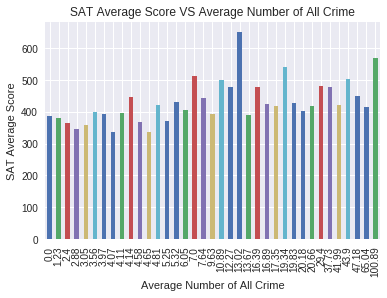

In [0]:
#bar plot with calculated mean SAT score
import matplotlib.pyplot as plt
import pandas as pd
dataforplot.groupby('AvgOfNoCrim N')['SAT AVG'].mean().plot(kind='bar')
plt.xlabel('Average Number of All Crime')
plt.ylabel('SAT Average Score')
plt.title('SAT Average Score VS Average Number of All Crime')
plt.show()

Text(0.5,1,u'SAT Average Score VS Number of Major Crime')

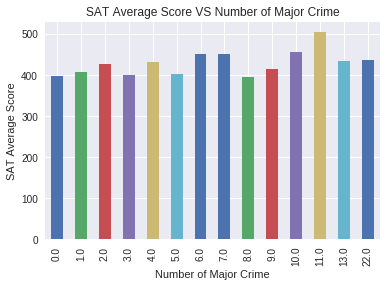

In [0]:
dataforplot.groupby('Major N')['SAT AVG'].mean().plot(kind='bar')
plt.xlabel('Number of Major Crime')
plt.ylabel('SAT Average Score')
plt.title('SAT Average Score VS Number of Major Crime')

Text(0.5,1,u'SAT Math Average Score VS Average Number of All Crime')

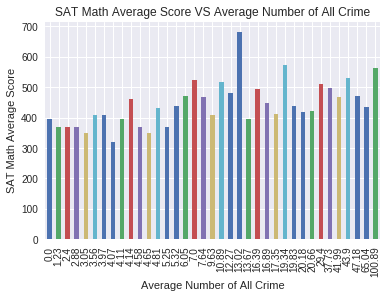

In [0]:
dataforplot.groupby('AvgOfNoCrim N')['SAT Math Avg. Score'].mean().plot(kind='bar')
plt.xlabel('Average Number of All Crime')
plt.ylabel('SAT Math Average Score')
plt.title('SAT Math Average Score VS Average Number of All Crime')

Text(0.5,1,u'SAT Math Average Score VS Number of Major Crime')

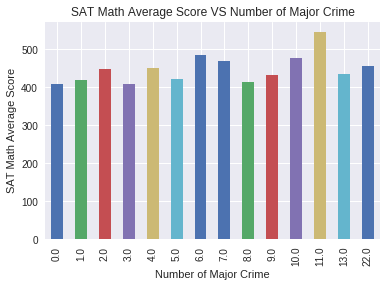

In [0]:
dataforplot.groupby('Major N')['SAT Math Avg. Score'].mean().plot(kind='bar')
plt.xlabel('Number of Major Crime')
plt.ylabel('SAT Math Average Score')
plt.title('SAT Math Average Score VS Number of Major Crime')

Text(0.5,1,u'SAT Average Score VS Number of Major Crime')

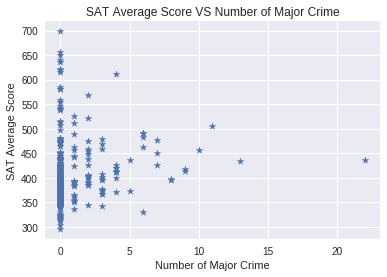

In [0]:
#scatter plot with raw data
plt.scatter(dataforplot['Major N'], dataforplot['SAT AVG'], marker="*")
plt.xlabel('Number of Major Crime')
plt.ylabel('SAT Average Score')
plt.title('SAT Average Score VS Number of Major Crime')

Text(0.5,1,u'SAT Math Avg. Score VS Number of Major Crime')

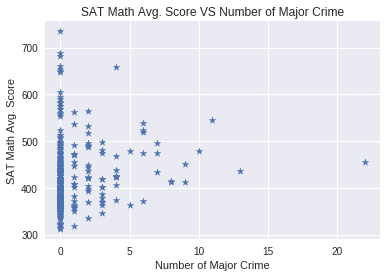

In [0]:
plt.scatter(dataforplot['Major N'], dataforplot['SAT Math Avg. Score'], marker="*")
plt.xlabel('Number of Major Crime')
plt.ylabel('SAT Math Avg. Score')
plt.title('SAT Math Avg. Score VS Number of Major Crime')

Text(0.5,1,u'SAT Math Avg. Score VS Average Number of All Crime')

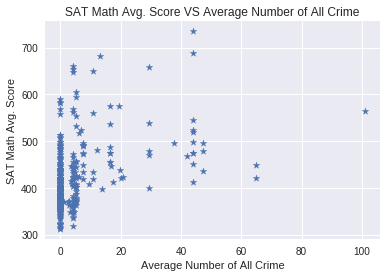

In [0]:
plt.scatter(dataforplot['AvgOfNoCrim N'], dataforplot['SAT Math Avg. Score'], marker="*")
plt.xlabel('Average Number of All Crime')
plt.ylabel('SAT Math Avg. Score')
plt.title('SAT Math Avg. Score VS Average Number of All Crime')

Text(0.5,1,u'SAT Average Score VS Average Number of All Crime')

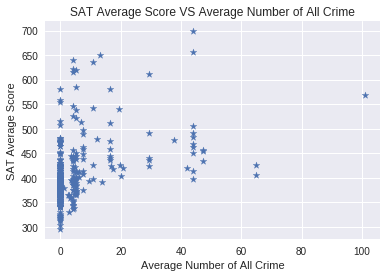

In [0]:
plt.scatter(dataforplot['AvgOfNoCrim N'], dataforplot['SAT AVG'], marker="*")
plt.xlabel('Average Number of All Crime')
plt.ylabel('SAT Average Score')
plt.title('SAT Average Score VS Average Number of All Crime')

While in the scatter plots I can better observe the distribution of SAT scores at different lovels of crime rate, in the bar chart I can have an idea of the average SAT score, which is not easy to observe in the scatter plot especially when crime is near zero, due to overlapping.

## **3.2 create geometry from the lat-lon coordinates and map the location of each school in the dataset**

In [0]:
newyork_map2 = folium.Map(location=[latitude, longitude], zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
schools = folium.map.FeatureGroup()

# loop through crimes and add each to the incidents feature group
for lat, lng, in zip(count_school.Latitude, count_school.Longitude):
    schools.add_child(
        folium.Marker(
            [lat, lng],
        )
    )

# add incidents to map
newyork_map2.add_child(schools)

# **4 Gather Asthma and drugs hospital discharge**

## **4.1 read in the SPARCS data**

In [0]:
sparcs_data = pd.read_csv('https://health.data.ny.gov/api/views/u4ud-w55t/rows.csv?accessType=DOWNLOAD')

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
sparcs_data.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,5511.95,5582.49
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,4783.20,5162.82
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,30 to 49,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3829.15,4056.52
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,0 to 17,147,F,White,Not Span/Hispanic,...,NaN,NaN,182357.0,NaN,NaN,0,N,Y,1108.20,1644.75
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,NaN,NaN,90301264.0,NaN,NaN,0,N,Y,3418.18,3370.87


In [0]:
sparcs_data.shape

(2544543, 37)

I only keep nyc data.

In [0]:
sparcs_5borough=sparcs_data[(sparcs_data['Hospital County'] == 'Kings') |(sparcs_data['Hospital County'] =='Queens')|(sparcs_data['Hospital County'] == 'Manhattan')|(sparcs_data['Hospital County'] == 'Bronx')|(sparcs_data['Hospital County'] == 'Richmond')]

In [0]:
sparcs_5borough.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility ID,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,Payment Typology 2,Payment Typology 3,Attending Provider License Number,Operating Provider License Number,Other Provider License Number,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
954417,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,F,Black/African American,Not Span/Hispanic,...,Medicaid,NaN,197201.0,NaN,NaN,0,N,Y,10408.87,8618.38
954464,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,M,Black/African American,Not Span/Hispanic,...,NaN,NaN,186946.0,NaN,NaN,0,N,Y,4652.69,3852.35
954762,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,30 to 49,104,F,Other Race,Spanish/Hispanic,...,Medicaid,NaN,3872.0,NaN,NaN,0,N,Y,4044.20,3348.53
954951,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,0 to 17,104,M,Other Race,Spanish/Hispanic,...,Medicaid,NaN,261112.0,NaN,NaN,0,N,Y,9130.51,7559.92
954967,New York City,Bronx,7000002.0,1165.0,Jacobi Medical Center,50 to 69,104,F,White,Not Span/Hispanic,...,NaN,NaN,253123.0,NaN,NaN,0,N,Y,4171.46,3453.90


In [0]:
sparcs_5borough.shape

(1199520, 37)

1345023 rows are eliminated

## **4.2 calculate the fraction of asthma and drug related diagnoses per facility (3 points)**

'Asthma', 'Respiratory failure; insufficiency; arrest (adult)', and  'Respiratory distress syndrome' for asthma related issue, and 'Poisoning by psychotropic agents', 'Alcohol-related disorders', and  'Substance-related disorders' for drug relates issues.

In [0]:
nycF=len(sparcs_5borough['Facility Name'].unique().tolist())
print("number of NYC facilities in the dataset", nycF)

('number of NYC facilities in the dataset', 61)


In [0]:
#count asthma related diagnoses per facility
sparcs_asthma=sparcs_5borough[(sparcs_5borough['CCS Diagnosis Description'] == 'Asthma') |(sparcs_data['CCS Diagnosis Description'] =='Respiratory failure; insufficiency; arrest (adult)')|(sparcs_data['CCS Diagnosis Description'] == 'Respiratory distress syndrome')]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [0]:
sparcs_asthma['CCS Diagnosis Description'].value_counts()

Asthma                                                24748
Respiratory failure; insufficiency; arrest (adult)     5915
Respiratory distress syndrome                            54
Name: CCS Diagnosis Description, dtype: int64

In [0]:
nyca = len(sparcs_asthma['CCS Diagnosis Description'])
print("number of asthma related cases in NYC", nyca) 

('number of asthma related cases in NYC', 30717)


In [0]:
#count drug related diagnoses per facility
sparcs_drug=sparcs_5borough[(sparcs_5borough['CCS Diagnosis Description'] == 'Poisoning by psychotropic agents') |(sparcs_data['CCS Diagnosis Description'] =='Alcohol-related disorders')|(sparcs_data['CCS Diagnosis Description'] == 'Substance-related disorders')]

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [0]:
sparcs_drug['CCS Diagnosis Description'].value_counts()

Alcohol-related disorders           27053
Substance-related disorders         17625
Poisoning by psychotropic agents     1658
Name: CCS Diagnosis Description, dtype: int64

In [0]:
nycd = len(sparcs_drug['CCS Diagnosis Description'])
print("number of drug related cases in NYC", nycd)

('number of drug related cases in NYC', 46336)


In [0]:
grouped_by_facility=sparcs_5borough.groupby('Facility Name').count()

In [0]:
grouped_by_asthma=sparcs_5borough[(sparcs_5borough['CCS Diagnosis Description'] == 'Asthma')|(sparcs_5borough['CCS Diagnosis Description'] == 'Respiratory failure; insufficiency; arrest (adult)')|(sparcs_5borough['CCS Diagnosis Description'] == 'Respiratory distress syndrome')].groupby('Facility Name').count()

In [0]:
grouped_by_drug=sparcs_5borough[(sparcs_5borough['CCS Diagnosis Description'] == 'Poisoning by psychotropic agents')|(sparcs_5borough['CCS Diagnosis Description'] == 'Alcohol-related disorders')|(sparcs_5borough['CCS Diagnosis Description'] == 'Substance-related disorders')].groupby('Facility Name').count()

In [0]:
ratio=pd.DataFrame(grouped_by_asthma['Gender']).rename(columns={'Gender':'Asthma'})
ratio['Drug']=grouped_by_drug['Gender'].rename(columns={'Gender':'Drug'})
ratio['All']=grouped_by_facility['Gender'].rename(columns={'Gender':'All'})

In [0]:
ratio.head()

,Asthma,Drug,All
Facility Name,,,
Bellevue Hospital Center,297,2420.0,23890
Bronx-Lebanon Hospital Center - Concourse Division,1351,337.0,24810
Brookdale Hospital Medical Center,899,185.0,16484
Brooklyn Hospital Center - Downtown Campus,652,783.0,18024
Calvary Hospital Inc,25,NaN,3043


In [0]:
ratio['Facility Name']=ratio.index
ratio.head()

,Asthma,Drug,All,Facility Name
Facility Name,,,,
Bellevue Hospital Center,297,2420.0,23890,Bellevue Hospital Center
Bronx-Lebanon Hospital Center - Concourse Division,1351,337.0,24810,Bronx-Lebanon Hospital Center - Concourse Divi...
Brookdale Hospital Medical Center,899,185.0,16484,Brookdale Hospital Medical Center
Brooklyn Hospital Center - Downtown Campus,652,783.0,18024,Brooklyn Hospital Center - Downtown Campus
Calvary Hospital Inc,25,NaN,3043,Calvary Hospital Inc


In [0]:
ratio = ratio.reset_index(drop=True)
ratio.head()

,Asthma,Drug,All,Facility Name
0,297,2420.0,23890,Bellevue Hospital Center
1,1351,337.0,24810,Bronx-Lebanon Hospital Center - Concourse Divi...
2,899,185.0,16484,Brookdale Hospital Medical Center
3,652,783.0,18024,Brooklyn Hospital Center - Downtown Campus
4,25,NaN,3043,Calvary Hospital Inc


Seems that some data is missing. I decide to drop NaN.

In [0]:
ratio=ratio.dropna(how='any')

In [0]:
ratio['Asthma Ratio']=ratio['Asthma']/ratio['All']
ratio['Drug Ratio']=ratio['Drug']/ratio['All']

In [0]:
ratio.head()

,Asthma,Drug,All,Facility Name,Asthma Ratio,Drug Ratio
0,297,2420.0,23890,Bellevue Hospital Center,0.012432,0.101298
1,1351,337.0,24810,Bronx-Lebanon Hospital Center - Concourse Divi...,0.054454,0.013583
2,899,185.0,16484,Brookdale Hospital Medical Center,0.054538,0.011223
3,652,783.0,18024,Brooklyn Hospital Center - Downtown Campus,0.036174,0.043442
5,520,1292.0,15187,Coney Island Hospital,0.034240,0.085073


In [0]:
ratio.shape

(52, 6)

## 4.3 find the location of each facility

In [0]:
from __future__ import print_function, division
SQL_SOURCE = 'https://fb55.carto.com:443/api/v2/sql?q='

import urllib2
import urllib
import StringIO
import ast
import pandas as pd

#will need to check the last 2 queries
import datetime as dt
import numpy as np

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    '''queries carto datasets from a given carto account
    Arguments: 
    query - string: a valid sql query string
    format - outlut format  OPTIONAL (default CSV)
    source - a valid sql api endpoint OPTIONAL (default carto fb55 account)
    Returns:
    the return of the sql query AS A STRING
    NOTES:
    designed for the carto API, tested only with CSV return format'''
    
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return response.read()

In [0]:
test = '''
SELECT *
FROM nyc_facilities
'''

In [0]:
facility_with_location=pd.read_csv(StringIO.StringIO(queryCartoDB(test)), sep=',')

In [0]:
facility_with_location.head()

,the_geom,regional_office,the_geom_webmercator,facility_id,facility_name,short_description,description,facility_open_date,facility_address_1,facility_address_2,...,cooperator_name,cooperator_address,cooperator_address_2,cooperator_city,cooperator_state,cooperator_zip_code,ownership_type,facility_latitude,facility_longitude,facility_location
0,0101000020E6100000E40F069E7B7C52C05952EE3EC753...,Metropolitan Area Regional Office - New York City,0101000020110F000046B5633099665FC167AF70FB3AED...,1320,University Hospital of Brooklyn,HOSP,Hospital,01/01/1901,445 Lenox Road,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,State,40.654518,-73.945045,"(40.654518, -73.945045)"
1,0101000020E61000008BC058DFC07852C04BC8073D9B53...,Metropolitan Area Regional Office - New York City,0101000020110F00001F2C777543605FC14E668BB709ED...,6448,PALA Community Care,DTC,Diagnostic and Treatment Center,09/12/2002,1110 Pennsylvania Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.653175,-73.886772,"(40.653175, -73.886772)"
2,0101000020E6100000D3DC0A61357D52C09AFF571D3958...,Metropolitan Area Regional Office - New York City,0101000020110F00006ACD5FB9D4675FC19AEE7C2435F2...,6754,Medcare LLC,DTC,Diagnostic and Treatment Center,02/26/2007,468 Lafayette Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,LLC,40.689243,-73.956383,"(40.689243, -73.956383)"
3,0101000020E61000006DCA15DEE57952C08A027D224F6C...,Metropolitan Area Regional Office - New York City,0101000020110F00007164F52335625FC110A7A85CBB08...,1206,P R O M E S A Inc,DTC,Diagnostic and Treatment Center,09/27/1979,1776 Clay Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.846165,-73.904655,"(40.846165, -73.904655)"
4,0101000020E6100000D6C4025FD17A52C038BF61A24168...,Metropolitan Area Regional Office - New York City,0101000020110F00006301C42AC5635FC1A351F0D12E04...,1207,Narco Freedom Inc,DTC,Diagnostic and Treatment Center,09/27/1979,479 Willis Avenue,NaN,...,NaN,NaN,NaN,NaN,New York,NaN,Not for Profit Corporation,40.814503,-73.919029,"(40.814503, -73.919029)"


In [0]:
facility_with_location=facility_with_location[['facility_id','facility_name','facility_latitude','facility_longitude']].rename(columns={'facility_name':'Facility Name'})
facility_with_location.head()

,facility_id,Facility Name,facility_latitude,facility_longitude
0,1320,University Hospital of Brooklyn,40.654518,-73.945045
1,6448,PALA Community Care,40.653175,-73.886772
2,6754,Medcare LLC,40.689243,-73.956383
3,1206,P R O M E S A Inc,40.846165,-73.904655
4,1207,Narco Freedom Inc,40.814503,-73.919029


In [0]:
facility_with_location.set_index('Facility Name')

,facility_id,facility_latitude,facility_longitude
Facility Name,,,
University Hospital of Brooklyn,1320,40.654518,-73.945045
PALA Community Care,6448,40.653175,-73.886772
Medcare LLC,6754,40.689243,-73.956383
P R O M E S A Inc,1206,40.846165,-73.904655
Narco Freedom Inc,1207,40.814503,-73.919029
Monroe Academy Campus,9580,40.831360,-73.899719
Rockaway Dialysis,9509,40.600143,-73.753967
New York City Department of Health and Mental Hygiene,286,40.749393,-73.939285
Waters Place Dialysis Center,9652,40.847191,-73.844780


In [0]:
df_merged = facility_with_location.merge(ratio, on='Facility Name')

In [0]:
df_merged.head()

,facility_id,Facility Name,facility_latitude,facility_longitude,Asthma,Drug,All,Asthma Ratio,Drug Ratio
0,1320,University Hospital of Brooklyn,40.654518,-73.945045,571,119.0,16928,0.033731,0.007030
1,1445,Harlem Hospital Center,40.814350,-73.940506,532,1169.0,11891,0.044740,0.098310
2,1309,Interfaith Medical Center,40.677940,-73.937515,422,1645.0,10658,0.039595,0.154344
3,1165,Jacobi Medical Center,40.857388,-73.846741,1123,1279.0,20956,0.053588,0.061033
4,1168,Montefiore Medical Center-Wakefield Hospital,40.894569,-73.861420,580,1006.0,15889,0.036503,0.063314


# 5. Aggregate at the PUMA level

## **5.1 getting PUMA geodata**

I am using folium to draw maps so I downloaded the puma dataset directly and give up this 10 points.

In [0]:
puma=pd.read_csv('https://serv.cusp.nyu.edu/~fbianco/finaldata2018/finalDataset.csv')

In [0]:
puma.head()

,puma,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SATmath,SATall,asthmaRatio,drugsRatio
0,3702,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.555556,374.740741,0.036503,0.063314
1,3704,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,417.750000,409.125000,0.037053,0.032269
2,3705,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,377.567568,372.558559,0.044207,0.202915
3,3707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,365.000000,356.833333,0.054454,0.013583
4,3709,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,372.250000,364.111111,0.057007,0.003671


# **6 checking collinearity and covariance of the data**

## **6.1 plot SAT features against each other and assess collinearity**

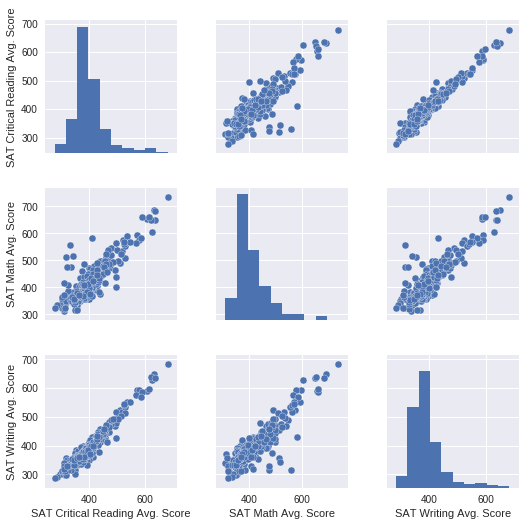

In [0]:
import seaborn as sns
sns.pairplot(school_sat_data[['SAT Critical Reading Avg. Score','SAT Math Avg. Score','SAT Writing Avg. Score']], size=2.5);

It seems to me that SAT writing score and SAT reading score have a higher colinearity with each other. Math is also colinear with them to some extent.

## 6.2 plot the SAT feature by PUMA against 3 of the crime features

Text(0.5,1,u'SAT Math Average Score VS Number of Major Crime')

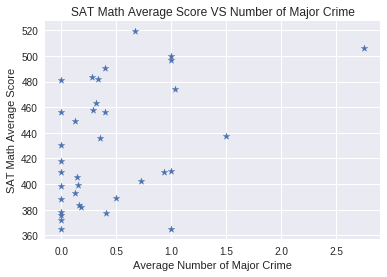

In [0]:
#scatter plot with puma data
plt.scatter(puma['Major N'], puma['SATmath'], marker="*")
plt.xlabel('Average Number of Major Crime')
plt.ylabel('SAT Math Average Score')
plt.title('SAT Math Average Score VS Number of Major Crime')

Text(0.5,1,u'SAT Math Average Score VS Average Number of Major Crime')

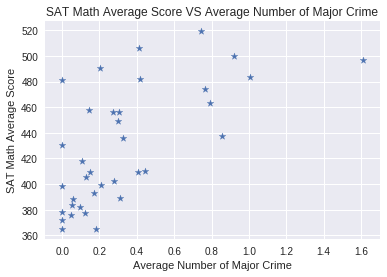

In [0]:
#scatter plot with puma data
plt.scatter(puma['AvgOfMajor N'], puma['SATmath'], marker="*")
plt.xlabel('Average Number of Major Crime')
plt.ylabel('SAT Math Average Score')
plt.title('SAT Math Average Score VS Average Number of Major Crime')

Text(0.5,1,u'SAT Math Average Score VS Average Number of Crime')

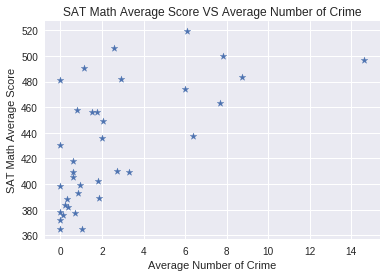

In [0]:
#scatter plot with puma data
plt.scatter(puma['AvgOfNoCrim N'], puma['SATmath'], marker="*")
plt.xlabel('Average Number of Crime')
plt.ylabel('SAT Math Average Score')
plt.title('SAT Math Average Score VS Average Number of Crime')

Text(0.5,1,u'SAT All Average Score VS Number of Major Crime')

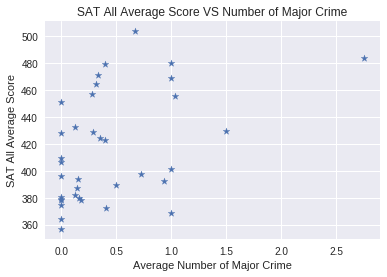

In [0]:
plt.scatter(puma['Major N'], puma['SATall'], marker="*")
plt.xlabel('Average Number of Major Crime')
plt.ylabel('SAT All Average Score')
plt.title('SAT All Average Score VS Number of Major Crime')

Text(0.5,1,u'SAT All Average Score VS Average Number of Major Crime')

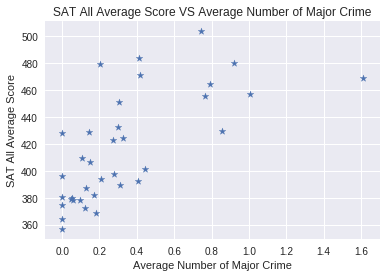

In [0]:
#scatter plot with puma data
plt.scatter(puma['AvgOfMajor N'], puma['SATall'], marker="*")
plt.xlabel('Average Number of Major Crime')
plt.ylabel('SAT All Average Score')
plt.title('SAT All Average Score VS Average Number of Major Crime')

Text(0.5,1,u'SAT All Average Score VS Average Number of Crime')

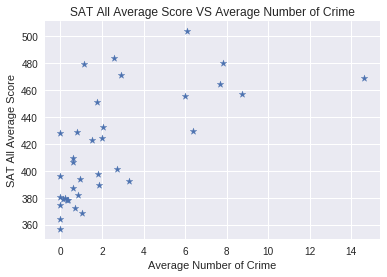

In [0]:
#scatter plot with puma data
plt.scatter(puma['AvgOfNoCrim N'], puma['SATall'], marker="*")
plt.xlabel('Average Number of Crime')
plt.ylabel('SAT All Average Score')
plt.title('SAT All Average Score VS Average Number of Crime')

## **6.3 plot the SAT feature against medical data**

Text(0.5,1,u'SAT All Average Score VS Ratio of Asthma')

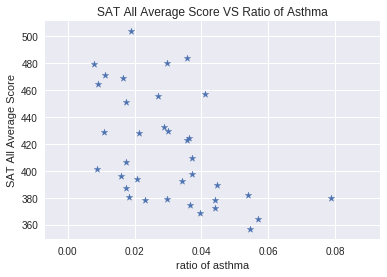

In [0]:
#scatter plot with puma data
plt.scatter(puma['asthmaRatio'], puma['SATall'], marker="*")
plt.xlabel('ratio of asthma')
plt.ylabel('SAT All Average Score')
plt.title('SAT All Average Score VS Ratio of Asthma')

Text(0.5,1,u'SAT Math Average Score VS Ratio of Asthma')

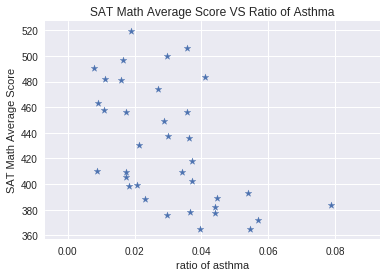

In [0]:
#scatter plot with puma data
plt.scatter(puma['asthmaRatio'], puma['SATmath'], marker="*")
plt.xlabel('ratio of asthma')
plt.ylabel('SAT Math Average Score')
plt.title('SAT Math Average Score VS Ratio of Asthma')

## extra

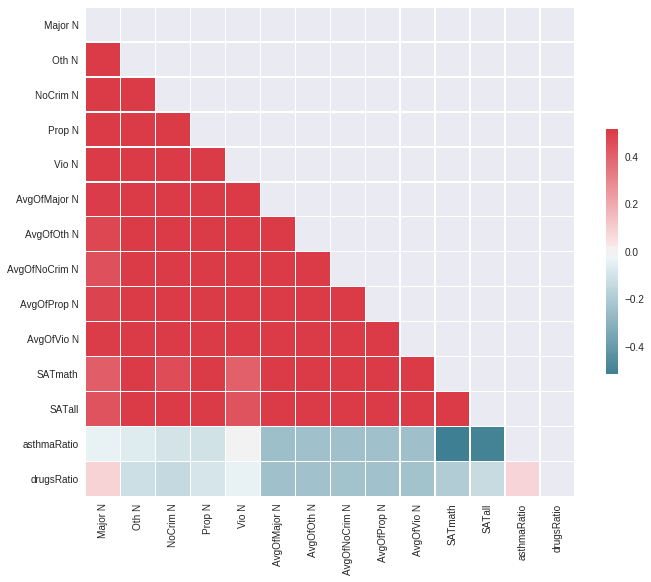

In [0]:
puma_drop=puma.drop(['puma'],axis=1)
corr = puma_drop.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# **7 Mapping**

## **7.1 the SAT features**

I am using a geojson file downloaded here: https://github.com/dwillis/nyc-maps/blob/master/boroughs.geojson

In [0]:
#https://github.com/dwillis/nyc-maps/blob/master/boroughs.geojson
from google.colab import files
uploaded = files.upload()

Saving boroughs.geojson to boroughs.geojson


In [0]:
merged.head()

,DBN,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,Borough,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT AVG
0,01M015,2.0,2.0,2.0,3.0,1.0,1.03,2.50,4.11,2.14,1.10,40.721807,-73.979022,M,0,0,0.0,0.0,0.0,0.0
1,01M019,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.729636,-73.983818,M,0,0,0.0,0.0,0.0,0.0
2,01M020,2.0,6.0,9.0,4.0,4.0,0.92,3.55,5.32,2.37,1.63,40.721540,-73.986648,M,0,0,0.0,0.0,0.0,0.0
3,01M034,0.0,4.0,4.0,1.0,3.0,0.89,3.07,4.14,2.16,1.42,40.726473,-73.975181,M,0,0,0.0,0.0,0.0,0.0
4,01M063,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,40.724117,-73.986381,M,0,0,0.0,0.0,0.0,0.0


I am removing the sat scores that are zero.

In [0]:
merged_for_sat_map=merged[ (merged['SAT Math Avg. Score'] > 0 ) & (merged['SAT AVG'] > 0 ) ]

In [0]:
merged_for_sat_map=merged_for_sat_map.dropna(how='any').groupby('Borough').mean().reset_index()

In [0]:
merged_for_sat_map

,Borough,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT AVG
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,384.750000,366.125000,372.625000,374.500000
1,K,0.731092,3.058824,4.907563,1.848739,1.462185,0.521681,2.258235,3.564454,1.519916,0.874874,40.664592,-73.945161,388.823529,399.302521,380.302521,389.476190
2,M,0.634615,2.528846,3.471154,1.903846,0.875000,0.503173,1.941538,3.511923,1.261538,0.876346,40.370765,-73.264856,417.432692,433.307692,412.240385,420.993590
3,O,0.000000,0.000000,0.000000,0.000000,0.000000,0.790000,1.790000,2.400000,1.630000,0.780000,0.000000,0.000000,367.000000,370.000000,360.000000,365.666667
4,Q,1.171429,5.257143,7.614286,3.485714,1.928571,1.233429,5.363000,9.728714,3.362143,2.251571,40.714780,-73.830809,420.114286,443.171429,412.085714,425.123810
5,R,2.166667,14.333333,25.416667,8.666667,4.833333,1.596667,6.842500,12.479167,4.252500,3.070833,40.591197,-74.128317,453.833333,462.916667,442.416667,453.055556
6,X,0.205607,1.327103,2.037383,0.654206,0.542056,0.162150,0.668879,1.083832,0.430748,0.287290,40.845266,-73.890295,381.084112,388.514019,376.102804,381.900312


In [0]:
merged_for_sat_map['Borough Full Name']=['None','Brooklyn','Manhattan','Other','Queens','Staten Island','Bronx']
merged_for_sat_map=merged_for_sat_map.drop(merged_for_sat_map.index[0])
merged_for_sat_map.head()

,Borough,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT AVG,Borough Full Name
1,K,0.731092,3.058824,4.907563,1.848739,1.462185,0.521681,2.258235,3.564454,1.519916,0.874874,40.664592,-73.945161,388.823529,399.302521,380.302521,389.476190,Brooklyn
2,M,0.634615,2.528846,3.471154,1.903846,0.875000,0.503173,1.941538,3.511923,1.261538,0.876346,40.370765,-73.264856,417.432692,433.307692,412.240385,420.993590,Manhattan
3,O,0.000000,0.000000,0.000000,0.000000,0.000000,0.790000,1.790000,2.400000,1.630000,0.780000,0.000000,0.000000,367.000000,370.000000,360.000000,365.666667,Other
4,Q,1.171429,5.257143,7.614286,3.485714,1.928571,1.233429,5.363000,9.728714,3.362143,2.251571,40.714780,-73.830809,420.114286,443.171429,412.085714,425.123810,Queens
5,R,2.166667,14.333333,25.416667,8.666667,4.833333,1.596667,6.842500,12.479167,4.252500,3.070833,40.591197,-74.128317,453.833333,462.916667,442.416667,453.055556,Staten Island


In [0]:
merged_for_sat_map=merged_for_sat_map.drop(merged_for_sat_map.index[2])

In [0]:
merged_for_sat_map.head()

,Borough,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,Latitude,Longitude,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT AVG,Borough Full Name
1,K,0.731092,3.058824,4.907563,1.848739,1.462185,0.521681,2.258235,3.564454,1.519916,0.874874,40.664592,-73.945161,388.823529,399.302521,380.302521,389.476190,Brooklyn
2,M,0.634615,2.528846,3.471154,1.903846,0.875000,0.503173,1.941538,3.511923,1.261538,0.876346,40.370765,-73.264856,417.432692,433.307692,412.240385,420.993590,Manhattan
4,Q,1.171429,5.257143,7.614286,3.485714,1.928571,1.233429,5.363000,9.728714,3.362143,2.251571,40.714780,-73.830809,420.114286,443.171429,412.085714,425.123810,Queens
5,R,2.166667,14.333333,25.416667,8.666667,4.833333,1.596667,6.842500,12.479167,4.252500,3.070833,40.591197,-74.128317,453.833333,462.916667,442.416667,453.055556,Staten Island
6,X,0.205607,1.327103,2.037383,0.654206,0.542056,0.162150,0.668879,1.083832,0.430748,0.287290,40.845266,-73.890295,381.084112,388.514019,376.102804,381.900312,Bronx


In [0]:
newyork_borough = 'boroughs.geojson'

# let Folium determine the scale.
newyork_map4 = folium.Map(location=[latitude, longitude], zoom_start=12)
newyork_map4.choropleth(
    geo_data=newyork_borough,
    data=merged_for_sat_map,
    name='choropleth',
    columns=['Borough Full Name', 'SAT AVG'],
    key_on='feature.properties.BoroName',
#     threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='New York sat MAP',
)
newyork_map4
newyork_map4.save('2.html')


I am writing this notebook using Google Colab. If you are reading this notebook in google colab, you can click the small arrow on the left side, and a small window will show you menu,code and files. Click on files and you will see the html files downloaded there. The html file can de downloaded here for convenience: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/2%20(2).html
When downloaded and opened you can see the choropleth map. Here is a screenshot: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/sat_choropleth.PNG

In [0]:

newyork_borough = 'boroughs.geojson'

# let Folium determine the scale.
newyork_map3 = folium.Map(location=[latitude, longitude], zoom_start=12)
newyork_map3.choropleth(
    geo_data=newyork_borough,
    data=merged_for_sat_map,
    name='choropleth',
    columns=['Borough Full Name', 'SAT Math Avg. Score'],
    key_on='feature.properties.BoroName',
#     threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='New York sat math MAP',
)
newyork_map3
newyork_map3.save('3.html')

The html file can de downloaded here for convenience: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/3.html When downloaded and opened you can see the choropleth map. Here is a screenshot: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/sat_math_choropleth.PNG

## **7.2 the two medical discharge features**

In [0]:
merged_for_medical_map_location=sparcs_5borough[['Hospital County','Facility Name']]
merged_for_medical_map=pd.merge(merged_for_medical_map_location,df_merged,on='Facility Name',how='inner')
merged_for_medical_map=merged_for_medical_map.drop_duplicates(subset='Facility Name',inplace=False)
merged_for_medical_map=merged_for_medical_map[['Asthma Ratio','Drug Ratio','Hospital County']]
merged_for_medical_map=merged_for_medical_map.groupby('Hospital County').mean().reset_index()
merged_for_medical_map

,Hospital County,Asthma Ratio,Drug Ratio
0,Bronx,0.045586,0.049764
1,Kings,0.035461,0.043028
2,Manhattan,0.017089,0.042086
3,Queens,0.024260,0.038108
4,Richmond,0.023411,0.097907


In [0]:
merged_for_medical_map['Borough Full Name']=['Bronx','Brooklyn','Manhattan','Queens','Staten Island']

In [0]:
newyork_borough = 'boroughs.geojson'

# let Folium determine the scale.
newyork_map6 = folium.Map(location=[latitude, longitude], zoom_start=12)
newyork_map6.choropleth(
    geo_data=newyork_borough,
    data=merged_for_medical_map,
    name='choropleth',
    columns=['Borough Full Name', 'Asthma Ratio'],
    key_on='feature.properties.BoroName',
#     threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='New York Medical MAP',
)
newyork_map6
newyork_map6.save('medical_map.html')

I am writing this notebook using Google Colab. The html file can de downloaded here for convenience: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/medical_map.html
When downloaded and opened you can see the choropleth map. Here is a screenshot: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/medical_choropleth.PNG

In [0]:
newyork_borough = 'boroughs.geojson'

# let Folium determine the scale.
newyork_map7 = folium.Map(location=[latitude, longitude], zoom_start=12)
newyork_map7.choropleth(
    geo_data=newyork_borough,
    data=merged_for_medical_map,
    name='choropleth',
    columns=['Borough Full Name', 'Drug Ratio'],
    key_on='feature.properties.BoroName',
#     threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='New York Medical MAP2',
)
newyork_map7
newyork_map7.save('medical_map2.html')

I am writing this notebook using Google Colab. The html file can de downloaded here for convenience: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/medical_map2.html When downloaded and opened you can see the choropleth map. Here is a screenshot: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/medical_map2.PNG

## **7.3 the 3 chosen school crime features**

In [0]:
merged_for_crime_map=merged[['Borough','Major N','AvgOfMajor N','AvgOfNoCrim N']]
merged_for_crime_map=merged_for_crime_map.groupby('Borough').sum()
merged_for_crime_map['Borough Full Name']=['None','Brooklyn','Manhattan','Other','Queens','Staten Island','Bronx']
merged_for_crime_map=merged_for_crime_map.drop(merged_for_crime_map.index[0])
merged_for_crime_map=merged_for_crime_map.drop(merged_for_crime_map.index[2])
merged_for_crime_map

,Major N,AvgOfMajor N,AvgOfNoCrim N,Borough Full Name
Borough,,,,
K,255.0,327.32,1964.72,Brooklyn
M,157.0,148.53,867.70,Manhattan
Q,184.0,390.44,2562.69,Queens
R,46.0,86.95,537.12,Staten Island
X,125.0,172.41,1018.71,Bronx


In [0]:
newyork_borough = 'boroughs.geojson'

# let Folium determine the scale.
newyork_map8 = folium.Map(location=[latitude, longitude], zoom_start=12)
newyork_map8.choropleth(
    geo_data=newyork_borough,
    data=merged_for_crime_map,
    name='choropleth',
    columns=['Borough Full Name', 'Major N'],
    key_on='feature.properties.BoroName',
#     threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='New York Major Crime MAP',
)
newyork_map8
newyork_map8.save('major_crime_map.html')

I am writing this notebook using Google Colab. The html file can de downloaded here for convenience: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/major_crime_map.html When downloaded and opened you can see the choropleth map. Here is a screenshot: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/major_crime_choropleth.PNG

In [0]:
newyork_borough = 'boroughs.geojson'

# let Folium determine the scale.
newyork_map10 = folium.Map(location=[latitude, longitude], zoom_start=12)
newyork_map10.choropleth(
    geo_data=newyork_borough,
    data=merged_for_crime_map,
    name='choropleth',
    columns=['Borough Full Name', 'AvgOfMajor N'],
    key_on='feature.properties.BoroName',
#     threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='New York Average of Major Crime MAP',
)
newyork_map10
newyork_map10.save('average_of_major_crime_map.html')

I am writing this notebook using Google Colab. The html file can de downloaded here for convenience: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/average_of_major_crime_map.html When downloaded and opened you can see the choropleth map. Here is a screenshot: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/average_major_crime.PNG

In [0]:
newyork_borough = 'boroughs.geojson'

# let Folium determine the scale.
newyork_map12 = folium.Map(location=[latitude, longitude], zoom_start=12)
newyork_map12.choropleth(
    geo_data=newyork_borough,
    data=merged_for_crime_map,
    name='choropleth',
    columns=['Borough Full Name', 'AvgOfNoCrim N'],
    key_on='feature.properties.BoroName',
#     threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='New York Average Number of Crime MAP',
)
newyork_map12
newyork_map12.save('average_number_of_crime_map.html')

I am writing this notebook using Google Colab. The html file can de downloaded here for convenience: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/average_number_of_crime_map.html When downloaded and opened you can see the choropleth map. Here is a screenshot: https://github.com/sueqian6/PUI2018_yq729/blob/master/final/average_number_crime.PNG

# **8 start with linear modeling**

## **8.1 create a multivariate-linear model using only the crime in school features, but using all 10 of them, predicting the chosen SAT feature**

In [0]:
# imports
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np

In [0]:
merged_for_linear_regression=merged[['Major N','Oth N','NoCrim N','Prop N','Vio N','AvgOfMajor N','AvgOfOth N','AvgOfNoCrim N','AvgOfProp N','AvgOfVio N','SAT AVG']]
merged_for_linear_regression.head()

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,SAT AVG
0,2.0,2.0,2.0,3.0,1.0,1.03,2.50,4.11,2.14,1.10,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0
2,2.0,6.0,9.0,4.0,4.0,0.92,3.55,5.32,2.37,1.63,0.0
3,0.0,4.0,4.0,1.0,3.0,0.89,3.07,4.14,2.16,1.42,0.0
4,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0


In [0]:
merged_for_linear_regression.rename(columns={'Major N':'MajorN',
                          'Oth N':'OthN',
                          'NoCrim N':'NoCrimN','Prop N':'PropN','Vio N':'VioN','AvgOfMajor N':'AvgOfMajorN','AvgOfOth N':'AvgOfOthN','AvgOfNoCrim N':'AvgOfNoCrimN','AvgOfProp N':'AvgOfPropN','AvgOfVio N':'AvgOfVioN','SAT AVG':'SATAVG'}, 
                 inplace=True)
 
print(merged_for_linear_regression.columns)

Index([u'MajorN', u'OthN', u'NoCrimN', u'PropN', u'VioN', u'AvgOfMajorN',
       u'AvgOfOthN', u'AvgOfNoCrimN', u'AvgOfPropN', u'AvgOfVioN', u'SATAVG'],
      dtype='object')


/usr/local/lib/python2.7/dist-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
lm1 = smf.ols(formula='SATAVG ~MajorN+OthN+NoCrimN+PropN+VioN +AvgOfMajorN+AvgOfOthN+AvgOfNoCrimN+AvgOfPropN+AvgOfVioN', data=merged_for_linear_regression).fit()

In [0]:
lm1.params

Intercept       103.050381
MajorN            5.312453
OthN             11.015413
NoCrimN           2.936560
PropN            -1.509670
VioN            -13.502917
AvgOfMajorN    -138.754869
AvgOfOthN       -14.339293
AvgOfNoCrimN     27.155853
AvgOfPropN       45.544257
AvgOfVioN       -81.723988
dtype: float64

In [0]:
### STATSMODELS ###

# print a summary of the fitted model
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATAVG   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     25.53
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           6.16e-46
Time:                        03:43:12   Log-Likelihood:                -12569.
No. Observations:                1939   AIC:                         2.516e+04
Df Residuals:                    1928   BIC:                         2.522e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      103.0504      4.688     21.980      0.000      93.856     112.245
MajorN           5.3125      8.624      0.616      0.538     -11.601      22.226
OthN            11.0154      6.539      1.685      0.092      -1.808      23.839
NoCrimN          2.9366      1.106      2.655      0.008       0.767       5.106
PropN           -1.5097      7.528     -0.201      0.841     -16.274      13.255
VioN           -13.5029      7.509     -1.798      0.072     -28.229       1.223
AvgOfMajorN   -138.7549     63.781     -2.175      0.030    -263.841     -13.668
AvgOfOthN      -14.3393     30.907     -0.464      0.643     -74.954      46.276
AvgOfNoCrimN    27.1559      3.946      6.881      0.000      19.417      34.895
AvgOfPropN      45.5443     40.517      1.124      0.261     -33.918     125.007
AvgOfVioN      -81.7240     37.011     -2.208      0.027    -154.310      -9.138
==============================================================================
Omnibus:                      421.751   Durbin-Watson:                   1.151
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              737.994
Skew:                           1.455   Prob(JB):                    5.58e-161
Kurtosis:                       3.814   Cond. No.                         279.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## **8.2 add drugs and asthma discharge data and create a new multilinear model**

In [0]:
puma_for_linear_regression=puma[['Major N','Oth N','NoCrim N','Prop N','Vio N','AvgOfMajor N','AvgOfOth N','AvgOfNoCrim N','AvgOfProp N','AvgOfVio N','asthmaRatio','drugsRatio','SATall']]
puma_for_linear_regression.head()

,Major N,Oth N,NoCrim N,Prop N,Vio N,AvgOfMajor N,AvgOfOth N,AvgOfNoCrim N,AvgOfProp N,AvgOfVio N,asthmaRatio,drugsRatio,SATall
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.036503,0.063314,374.740741
1,0.000000,2.625000,1.625000,1.375000,1.000000,0.108750,0.416250,0.601250,0.282500,0.188750,0.037053,0.032269,409.125000
2,0.405405,2.162162,3.540541,0.945946,1.054054,0.123243,0.461081,0.685135,0.311351,0.212162,0.044207,0.202915,372.558559
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.054454,0.013583,356.833333
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.057007,0.003671,364.111111


In [0]:
puma_for_linear_regression.rename(columns={'Major N':'MajorN',
                          'Oth N':'OthN',
                          'NoCrim N':'NoCrimN','Prop N':'PropN','Vio N':'VioN','AvgOfMajor N':'AvgOfMajorN','AvgOfOth N':'AvgOfOthN','AvgOfNoCrim N':'AvgOfNoCrimN','AvgOfProp N':'AvgOfPropN','AvgOfVio N':'AvgOfVioN'}, 
                 inplace=True)
 
print(puma_for_linear_regression.columns)

Index([u'MajorN', u'OthN', u'NoCrimN', u'PropN', u'VioN', u'AvgOfMajorN',
       u'AvgOfOthN', u'AvgOfNoCrimN', u'AvgOfPropN', u'AvgOfVioN',
       u'asthmaRatio', u'drugsRatio', u'SATall'],
      dtype='object')


In [0]:
lm2 = smf.ols(formula='SATall ~MajorN+OthN+NoCrimN+PropN+VioN +AvgOfMajorN+AvgOfOthN+AvgOfNoCrimN+AvgOfPropN+AvgOfVioN+asthmaRatio+drugsRatio', data=puma_for_linear_regression).fit()

In [0]:
lm2.params

Intercept       418.941191
MajorN           69.876711
OthN             56.305711
NoCrimN          -4.471843
PropN           -64.585684
VioN            -53.319711
AvgOfMajorN     107.062638
AvgOfOthN       -23.481871
AvgOfNoCrimN     -2.220855
AvgOfPropN       23.706619
AvgOfVioN         7.038856
asthmaRatio    -996.765924
drugsRatio      -10.063683
dtype: float64

The correlation between asthmaRatio/drugRatio and SAT scores is much higher than crime rate. They both negatively impact students' academic performance.

In [0]:
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     3.968
Date:                Mon, 17 Dec 2018   Prob (F-statistic):            0.00222
Time:                        03:47:22   Log-Likelihood:                -163.66
No. Observations:                  36   AIC:                             353.3
Df Residuals:                      23   BIC:                             373.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      418.9412     16.128     25.976      0.000     385.578     452.304
MajorN          69.8767     37.284      1.874      0.074      -7.250     147.004
OthN            56.3057     29.021      1.940      0.065      -3.729     116.341
NoCrimN         -4.4718      5.239     -0.854      0.402     -15.310       6.366
PropN          -64.5857     32.561     -1.984      0.059    -131.942       2.771
VioN           -53.3197     34.054     -1.566      0.131    -123.765      17.126
AvgOfMajorN    107.0626    453.581      0.236      0.815    -831.241    1045.366
AvgOfOthN      -23.4819    182.273     -0.129      0.899    -400.542     353.578
AvgOfNoCrimN    -2.2209     25.443     -0.087      0.931     -54.854      50.413
AvgOfPropN      23.7066    266.953      0.089      0.930    -528.527     575.941
AvgOfVioN        7.0389    258.328      0.027      0.978    -527.352     541.430
asthmaRatio   -996.7659    337.751     -2.951      0.007   -1695.458    -298.074
drugsRatio     -10.0637     90.359     -0.111      0.912    -196.986     176.858
==============================================================================
Omnibus:                        1.265   Durbin-Watson:                   1.862
Prob(Omnibus):                  0.531   Jarque-Bera (JB):                0.828
Skew:                           0.371   Prob(JB):                        0.661
Kurtosis:                       2.989   Cond. No.                         885.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# **9 compare the linear models**

## **9.1 How Well Does the Model Fit the data?**

In [0]:
# print the R-squared value for the model 1
lm1.rsquared

0.34478292613019523

In [0]:
# print the R-squared value for the model 2
lm2.rsquared

0.6743021674026926

Higher values are better because it means that more variance is explained by the model. Model 2 seems better in this case.

## **9.2 Calculating RMSE**

In [0]:
# exclude medical
X = merged_for_linear_regression[['MajorN','OthN','NoCrimN','PropN','VioN' ,'AvgOfMajorN','AvgOfOthN','AvgOfNoCrimN','AvgOfPropN','AvgOfVioN']]
y = merged_for_linear_regression.SATAVG

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Instantiate model
lm1 = LinearRegression()

# Fit Model
lm1.fit(X_train, y_train)

# Predict
y_pred = lm1.predict(X_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

50.52181904733889


In [0]:
# include medical
X = puma_for_linear_regression[['MajorN','OthN','NoCrimN','PropN','VioN' ,'AvgOfMajorN','AvgOfOthN','AvgOfNoCrimN','AvgOfPropN','AvgOfVioN','asthmaRatio','drugsRatio']]
y = puma_for_linear_regression.SATall

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

# Instantiate model
lm2 = LinearRegression()

# Fit Model
lm2.fit(X_train, y_train)

# Predict
y_pred = lm2.predict(X_test)

# RMSE
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

36.70261318235068


Model 2 has a lower RMSE value so it is better.

## **9.3 Likelihood Ratio Test**

Comparing the two models without nd with medical variables respectedly with Likelihood Ratio LR test; we require a significance alpha=0.05
The models can be compared with LR test because they are nested models

The difference in the number of degrees of freedom is 2, so the LR statistics will follow a $\chi^2$ distribution with 2 DOF.

In [0]:
alpha = 0.05
print ("LR : ", -2 * (lm1.llf - (lm2.llf)))
print ("LR from statsmodels:", lm2.compare_lr_test(lm1))
LR = lm2.compare_lr_test(lm1)

print ("We ")
if LR[0] < 5.99: #0.05 level for 2 DOF chi sq distribution 
    print ("CANNOT") 
    
print ("reject the Null hypothesis that the model without medical variables " + 
       " is better than the 2nd model with medical variables with p-value ")
print ("p < %.3f"%alpha)

LR :  24810.394148640644
LR from statsmodels: (24810.394148640644, 0.0, 1905.0)
We 
reject the Null hypothesis that the model without medical variables  is better than the 2nd model with medical variables with p-value 
p < 0.050


In order to further compare the two models, here is a hypothesis: medical issues have an influence on sat scores. The null hypothesis is that they do not influence sat scores.
In part 8 I printed summaries of the two models. AsthmaRatio has  a small p-value, whereas drugratio has  a large p-value
Reject the null hypothesis for asthmaRatio. There is association between asthmaratio and sat scores.
Fail to reject the null hypothesis for drugRatio.There is no association.
I think from the aspect of p-value, a third model with asthmaratio but not frug ratio would be better.

In [0]:
lm3 = smf.ols(formula='SATall ~MajorN+OthN+NoCrimN+PropN+VioN +AvgOfMajorN+AvgOfOthN+AvgOfNoCrimN+AvgOfPropN+AvgOfVioN+asthmaRatio', data=puma_for_linear_regression).fit()

In [0]:
lm3.params

Intercept       418.241271
MajorN           68.770300
OthN             55.729382
NoCrimN          -4.392015
PropN           -63.939783
VioN            -52.678534
AvgOfMajorN     118.723364
AvgOfOthN       -19.793395
AvgOfNoCrimN     -2.754389
AvgOfPropN       18.522209
AvgOfVioN         2.278588
asthmaRatio    -995.997993
dtype: float64

In [0]:
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 SATall   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     4.513
Date:                Mon, 17 Dec 2018   Prob (F-statistic):           0.000988
Time:                        04:01:09   Log-Likelihood:                -163.67
No. Observations:                  36   AIC:                             351.3
Df Residuals:                      24   BIC:                             370.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      418.2413     14.544     28.756      0.000     388.223     448.259
MajorN          68.7703     35.189      1.954      0.062      -3.856     141.396
OthN            55.7294     27.962      1.993      0.058      -1.982     113.441
NoCrimN         -4.3920      5.082     -0.864      0.396     -14.881       6.097
PropN          -63.9398     31.374     -2.038      0.053    -128.692       0.813
VioN           -52.6785     32.866     -1.603      0.122    -120.510      15.153
AvgOfMajorN    118.7234    432.156      0.275      0.786    -773.203    1010.650
AvgOfOthN      -19.7934    175.512     -0.113      0.911    -382.033     342.446
AvgOfNoCrimN    -2.7544     24.469     -0.113      0.911     -53.256      47.747
AvgOfPropN      18.5222    257.398      0.072      0.943    -512.721     549.765
AvgOfVioN        2.2786    249.470      0.009      0.993    -512.603     517.160
asthmaRatio   -995.9980    330.660     -3.012      0.006   -1678.447    -313.549
==============================================================================
Omnibus:                        1.226   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.542   Jarque-Bera (JB):                0.776
Skew:                           0.359   Prob(JB):                        0.679
Kurtosis:                       3.007   Cond. No.                         863.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# **10 random forest regression on school-related data only**

## **10.1 create a random forest model using only the crime in school data, but using all 10 crime in school features **

In [0]:
from sklearn.ensemble  import RandomForestRegressor as rfr

In [0]:
X = merged_for_linear_regression[['MajorN','OthN','NoCrimN','PropN','VioN' ,'AvgOfMajorN','AvgOfOthN','AvgOfNoCrimN','AvgOfPropN','AvgOfVioN']]
y = merged_for_linear_regression.SATAVG

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
clf=rfr()
clf.fit(X_train, y_train)

/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred = clf.predict(X_test)

In [0]:
clf.score(X,y,sample_weight=None)

0.25101245850334775

## **10.2 measure the feature importance of the features in this model to select the 3 most predictive features**

In [0]:
clf.feature_importances_

array([0.03566665, 0.08702786, 0.32954167, 0.09361488, 0.08585899,
       0.07054071, 0.0442772 , 0.06213112, 0.07670098, 0.11463992])

Vio N, AvgOfProp N and AvgOfVio N are the 3 most predictive features

# **11 random forest with crime and medical (and income if you have it) features**

## **11.1 create a random forest model that only uses the 3 most predictive features about school crimes and the health features (and income if you have it from the EC)**

In [0]:
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.ensemble  import GradientBoostingClassifier as gdb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [0]:
X = puma_for_linear_regression[['MajorN','OthN','NoCrimN','PropN','VioN' ,'AvgOfMajorN','AvgOfOthN','AvgOfNoCrimN','AvgOfPropN','AvgOfVioN','asthmaRatio','drugsRatio']]
X = preprocessing.scale(X)
y = puma_for_linear_regression.SATall

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
clf=rfr()
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred = clf.predict(X_test)

In [0]:
clf.score(X,y,sample_weight=None)

0.7621452785036396

In [0]:
clf.feature_importances_

array([0.01305214, 0.014003  , 0.02260132, 0.04059698, 0.01878104,
       0.06309209, 0.24660205, 0.1252215 , 0.00517812, 0.15081564,
       0.21067811, 0.08937802])

'AvgOfVioN','asthmaRatio' and 'AvgOfMajorN' are the 3 most predictive features.

In [0]:
X = puma_for_linear_regression[['AvgOfMajorN','AvgOfVioN','asthmaRatio']]
y = puma_for_linear_regression.SATall

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
clf=rfr()
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## **11.2 evaluate the performance of the model**

In [0]:
y_pred = clf.predict(X_test)

In [0]:
clf.score(X,y,sample_weight=None)

0.7660990175506988

## 11.3 discuss the importance of each feature in the model

In [0]:
features= X
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [0]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: AvgOfVioN            Importance: 0.53
Variable: AvgOfMajorN          Importance: 0.24
Variable: asthmaRatio          Importance: 0.24


AvgOfMajorN has the most impact on sat scores, while the other 2 features has similar and lower impact on the sat scores.